(perc-lab)=
# Perceptron

In [1]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl        # plotting

In [2]:
import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


## Uczenie nadzorowane

We have shown in the previous chapters that even the simplest ANNs can carry out useful tasks (emulate logical networks or provide simple memory models). Generally, each ANN has

- a certain **architecture**, i.e. the number of layers, number of neurons in each layer, scheme of connections between the neurons (fully connected or not, feed forward, recurrent, ...);

- **weights (hyperparameters)**, with specific values, defining the network's functionality.

The prime practical question is how to set (for a given architecture) the weights such that a requested goal is realized, i.e., a given input yields a desired output. 
In the tasks discussed earlier, the weights could be constructed *a priori*, be it for the logical gates or for the memory models. However, for more involved applications we want to have an "easier" way of determining the weights. Actually, for complicated problems a "theoretical" a priori determination of weights is not possible at all. This is the basic reason for inventing **learning algorithms**, which automatically adjust the weights with the help of the available data. 

In this chapter we begin to explore such algorithms with the **supervised learning** approach, used i.a. for data classification.  

W poprzednich rozdziałach pokazaliśmy, że nawet najprostsze sieci ANN mogą wykonywać przydatne zadania (emulować sieci logiczne lub dostarczać proste modele pamięci). Ogólnie rzecz biorąc, każdy ANN ma

- pewną **architekturę**, czyli liczbę warstw, liczbę neuronów w każdej warstwie, schemat połączeń między neuronami (w pełni połączone lub nie, feed-forward, rekurencyjne, ...);

- **wagi (hiperparametry)** na połącznieach, z określonymi wartościami definiującymi funkcjonalność sieci.

Podstawowym pytaniem praktycznym jest to, jak ustawić (dla danej architektury) wagi tak, aby żądany cel funkcjonalności sieci został zrealizowany, tj. dla określonych danych wejściowych uzuskać pożądany wynik na wyjściu.
W zadaniach omówionych wcześniej wagi mogą być skonstruowane *a priori*, czy to dla bramek logicznych, czy dla modeli pamięci. Jednak dla bardziej skomplikowanych aplikacji chcemy mieć „łatwiejszy” sposób określania wag. Co więcej, dla skomplikowanych problemów „teoretyczne” określenie wag a priori nie jest w ogóle możliwe. To podstawowy powód, dla którego wymyślono **algorytmy uczenia się** sieci, które ,,automatycznie" dostosowują wagi na podstawie dostępnych danych.

W tym rozdziale rozpoczynamy badanie takich algorytmów, poczynając od podejścia **uczenia nadzorowanego**, stosowanego m.in. do klasyfikacji danych.

```{admonition} Uczenie nadzorowane
:class: important

W tej strategii dane muszą posiadać **etykiety**, które a priori określają poprawną kategorię dla każdego punktu. Pomyślmy na przykład o zdjęciach zwierząt (dane lub cechy, ang. features) i ich opisach (kot, pies,...), które nazywane są etykietami (ang. labels).
Te etykietowane dane są następnie dzielone na próbkę **szkoleniową** i próbkę **testową**.

Podstawowe kroki uczenia nadzorowanego dla danej ANN są następujące:

- Zainicjuj w jakiś sposób wagi, na przykład losowo lub na zero.

- Odczytuj kolejno punkty danych z próbki szkoleniowej i przepuszczaj je przez swoją sieć ANN. Otrzymana odpowiedź może różnić się od prawidłowej, zawartej w etykiecie. W takim przypadku wagi są zmieniane zgodnie z konkretną receptą (o czym później).

- W razie potrzeby powtórz poprzedni krok. Zazwyczaj wagi zmienia się coraz mniej w miarę postępu algorytmu.

- Zakończ szkolenie sieci po osiągnięciu kryterium zatrzymania (wagi nie zmieniają się już znacznie lub została osiągnięta maksymalna liczba iteracji).

- Przetestuj tak wyszkoloną ANN na próbce testowej.

Jeśli jesteśmy zadowoleni, mamy pożądaną wyszkoloną sieć ANN wykonującą określone zadanie (takie jak np. klasyfikacja danych), której można teraz używać na nowych, nieetykietowanych danych. Jeśli nie, możemy inaczej podzielić próbkę na część szkoleniową i testową, po czym powtórzyć procedurę uczenia od początku. Możemy także spróbować pozyskać więcej danych (co może być kosztowne), lub też zmienić architekturę sieci.

Termin „nadzorowany” pochodzi z interpretacji procedury, w której etykiety posiadane są przez „nauczyciela”, który w ten sposób wie, które odpowiedzi są prawidłowe, a które błędne i który **nadzoruje** w ten sposób proces szkolenia. Oczywiście program komputerowy ma wbudowanego nauczyciela. tj. "nadzoruje się" sam.
```

## Perceptron jako klasyfikator binarny

Najprostszy algorytm uczenia nadzorowanego
to [perceptron](https://en.wikipedia.org/wiki/Perceptron), wymyślony w 1958 roku przez Franka Rosenblatta. Może służyć m.in. do
konstruowania **klasyfikatorów binarnych** danych. *Binarny* oznacza, że sieć
służy do oceny, czy element danych ma określoną cechę, czy nie - są tylko dwie możliwości. Klasyfikacja wieloetykietowa jest również możliwa w przypadku ANN (patrz ćwiczenia), ale nie omawiamy jej tutaj.

```{Admonition} Uwaga
:class: note
Termin *perceptron* jest również używany dla ANN (bez lub z warstwami pośrednimi) składających się z neuronów MCP (por. rys. {numref}`ffnn-fig` i {numref}`MCP1-fig`), na których wykonywany jest algorytm perceptronu.
```

### Próbka ze znaną regułą klasyfikacji

Na początek potrzebujemy danych treningowych, które wygenerujemy jako losowe punkty w kwadracie. Zatem współrzędne punktu, $x_1$ i $x_2$, należą do przedziału $[0,1]$. Definiujemy dwie kategorie: jedną dla punktów leżących powyżej linii $x_1=x_2$ (nazwijmy je różowymi) oraz drugą dla punktów leżących poniżej tej linii (niebieskie). Podczas losowego generowania danych sprawdzamy, czy $x_2 > x_1$ czy nie i przypisujemy odpowiednią  **etykietę** do każdego punktu, równą odpowiednio 1 lub 0. Te etykiety są oczekiwanymi „prawdziwymi” odpowiedziami sieci po jej wyszkoleniu.

Funkcja generująca opisany powyżej punkt danych z etykietą to

In [3]:
def point():     # generates random coordinates x1, x2, and 1 if x2>x1, 0 otherwise
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1):                     # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

Generujemy **próbkę szkoleniową**, składającą się z **npo**=300 etykietowanych punktów danych:

In [4]:
npo=300 # number of data points in the training sample

print('  x1         x2         label')       # header
samp=np.array([point() for _ in range(npo)]) # training sample, _ is dummy iterator
print(samp[:5, :])                           # first 5 data points

  x1         x2         label
[[0.46285883 0.3416124  0.        ]
 [0.0786541  0.97754298 1.        ]
 [0.94877867 0.11418343 0.        ]
 [0.10083775 0.52628322 1.        ]
 [0.07153033 0.03834285 0.        ]]


```{admonition} Pętle w tablicy
:class: warning

W Pythonie można wygodnie zdefiniować tablicę poprzez pętlę, np.
[i**2 for i in range(4)] yields [1,4,9].

W pętlach, jeśli wskaźnik nie występuje jawnie w wyrażeniu, można użyć ,,ślepego'' wskaźnika **_**, na przykład

[point() for _ in range(npo)]
```

```{admonition} Zakresy w tablicach
:class: warning

Aby nie drukować niepotrzebnie bardzo długiej tabeli, po raz pierwszy użyliśmy powyżej **zakresów dla wskaźników tablic**. Np. 2:5 oznacza od 2 do 4 (przypomnijmy, że ostatni jest wykluczony!), :5 - od 0 do 4, 5: - od 5 do końca, wreszcie : - wszystkie elementy.
```

Nasze wygenerowane dane przedstawia graficznie poniższy rysunek. Wykreślamy również linię $x_2=x_1$, która oddziela niebieskie i różowe punkty. W tym przypadku podział jest możliwy a priori (znamy regułę) w sposób dokładny.

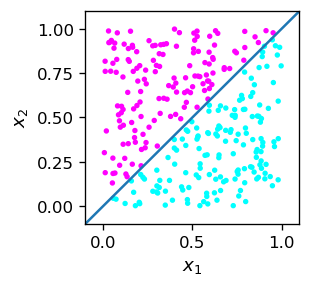

In [21]:
plt.figure(figsize=(2.3,2.3),dpi=120)                 
plt.xlim(-.1,1.1)                                  # axes limits
plt.ylim(-.1,1.1)
plt.scatter(samp[:,0],samp[:,1],c=samp[:,2],       # label determines the color
            s=5,cmap=mpl.cm.cool)                  # point size and color

plt.plot([-0.1, 1.1], [-0.1, 1.1])                 # separating line

plt.xlabel('$x_1$',fontsize=11)                    
plt.ylabel('$x_2$',fontsize=11)

plt.show()

```{admonition} Zbiory liniowo rozłączne
:class: important

Dwa zbiory punktów (tutaj niebieski i różowy) na płaszczyźnie, które można rozdzielić linią prostą, nazywamy **liniowo rozłącznymi** (separowalnymi). W trzech wymiarach zbiory muszą być separowalne płaszczyzną, ogólnie w $n$ wymiarach  zbiory muszą być separowalne za pomocą  $n-1$ wymiarowej hiperpłaszczyzny.
```

Analitycznie, jeżeli punkty w przestrzeni $n$ wymiarowej  mają współrzędne $(x_1,x_2,\dots,x_n)$, to można dobrać parametry $(w_0,w_1,\dots,w_n)$ w taki sposób, aby zbiór jeden punktów spełniał warunek

```{math}
:label: eq-linsep

w_0+x_1 w_1+x_2 w_2 + \dots x_n w_n > 0
```

a drugi warunek przeciwny, ze znakiem $>$ zastąpionym przez $\le$.

A teraz kluczowa, choć oczywista obserwacja: powyższa nierówność jest dokładnie warunkiem zaimplementowanym w [neuronie MCP](laboratorium MCP) (ze schodkową funkcją aktywacji) w konwencji {numref}`MCP2-fig`! Możemy więc zrealizować warunek {eq}`eq-linsep` za pomocą funkcji **neuron** z biblioteki **neural**.

W naszym przykładzie dla różowych punktów, według konstrukcji,

$$
x_2>x_1 \to s=-x_1+x_2 >0
$$

skąd, używając równ. {eq}`eq-linsep`, możemy od razu odczytać

$$
w_0=0, \;\; w_1=-1, w_2=1.
$$

Zatem funkcja **neuron** dla punktu próbki p jest używana w następujący sposób:

In [22]:
p=[0.6,0.8]      # sample point with x_2 > x_1
w=[0,-1,1]       # weights as given above

func.neuron(p,w) 

1

Neuron, odpalił, więc punkt p jest różowy.

```{admonition} Wniosek
:class: important

Pojedynczy neuron MCP z odpowiednio dobranymi wagami może być użyty jako klasyfikator binarny dla $n$-wymiarowych danych separowalnych.
```

### Próbka o nieznanej regule klasyfikacji

At this point the reader may be a bit misled by the apparent triviality of the results. The confusion may stem from the fact that in the above example we knew from the outset the rule defining the two classes of points ($x_2>x_1$, or opposite). However, in a general "real life" situation this is usually not the case! Imagine that we encounter the (labeled) data **samp2** looking like this: 

In [7]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):               # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

In [8]:
samp2=np.array([point2() for _ in range(npo)])              

In [9]:
print(samp2[:5])

[[0.09404635 0.29135793 0.        ]
 [0.89722866 0.11321874 0.        ]
 [0.8268489  0.38199441 0.        ]
 [0.6606985  0.98391123 1.        ]
 [0.4937868  0.52659543 1.        ]]


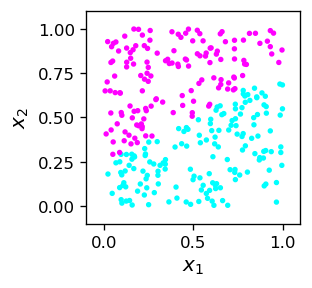

In [10]:
plt.figure(figsize=(2.3,2.3),dpi=120)                 
plt.xlim(-.1,1.1)                                  
plt.ylim(-.1,1.1)
plt.scatter(samp2[:,0],samp2[:,1],c=samp2[:,2],     
            s=5,cmap=mpl.cm.cool)                  

plt.xlabel('$x_1$',fontsize=12)                    
plt.ylabel('$x_2$',fontsize=12)

plt.show()

The situation is in some sense inverted now. We have obtained from somewhere the (linearly separable) data, and want to find the rule that defines the two classes. In other words, we need to draw a dividing line, which is equivalent to finding the weights of the MCP neuron of {numref}`MCP2-fig` that would carry out the binary classification.

(lab-pa)=
## Perceptron algorithm

We could still try to figure out somehow the proper weights for the present example and find the dividing line, for instance with a ruler and pencil, but this is not the point. We wish to have a systematic algorithmic procedure that will effortlessly work for this one and any similar situation. The answer is the already mentioned [perceptron algorithm](https://en.wikipedia.org/wiki/Perceptron). 

Before presenting the algorithm, let us remark that the MCP neuron with some set of weights $w_0, w_1, w_2$ always yields some answer for a labeled data point, correct or wrong. For example

In [11]:
w=[-0.5,1,0]           # arbitrary choice of weights

print("label  answer") # header

for i in range(5): # look at first 5 points
    print(int(samp2[i,2]),"    ",func.neuron(samp2[i,:2],w)) 
            # samp2[i,2] is the label, samp2[i,:2] is [x_1,x_2]

label  answer
0      0
0      1
0      1
1      1
1      0


We can see that some answers are equal to the corresponding labels (correct), and some are different (wrong). The general idea now is to **use the wrong answers** to adjust cleverly, in small steps, the weights, such that after sufficiently many iterations we get all the answers for the training sample correct!

```{admonition} Perceptron algorithm
:class: important

We iterate over the points of the training data sample.
If for a given point  the obtained result $y_o$ is equal to the true value $y_t$ (the label), i.e. the answer is  correct, we do nothing. However, if it is wrong, we change the weights a bit, such that the chance of getting the wrong answer decreases. The explicit recipe is as follows:

$w_i \to w_i  +  \varepsilon  (y_t - y_o)  x_i$,

where $ \varepsilon $ is a small number (called the **learning speed**) and $x_i$ are the coordinates of the input point, with $i=0,\dots,n$. 
```

Let us follow how it works. Suppose first that $ x_i> 0$. Then if the label $ y_t = 1 $ is greater than the obtained answer $ y_o = 0$, the weight $w_i$ is increased. Then $ w \cdot x $ also increases and $ y_o = f (w \cdot x) $ is more likely to acquire the correct value of 1 (we remember how the step function $f$ looks like). If, on the other hand, the label $ y_t = 0 $ is less than the obtained answer $ y_o = 1 $, then the weight $w_i$ is decreased, $ w \cdot x $ decreases, and $ y_o = f (w \cdot x) $ has a better chance of achieving the correct value of 0.

If $ x_i < 0 $ it is easy to analogously check that the recipe also works properly.

When the answer is correct, $y_t=y_0$, then $ w_i \to w_i$, so nothing changes. We do not "spoil" the perceptron!

The above formula can be used many times for the same point from the training sample. Next,  we loop over all the points of the sample, and the whole procedure can still be repeated in many rounds to obtain stable weights (not changing any more as we continue the procedure, or changing only slightly).

Typically, in such algorithms the learning speed $ \varepsilon $ is being decreased in successive rounds. This is technically very important, because too large updates could spoil the obtained solution.

The Python implementation of the perceptron algorithm for the 2-dimensional data is as follows:

In [12]:
w0=np.random.random()-0.5  # initialize weights randomly in the range [-0.5,0.5]
w1=np.random.random()-0.5
w2=np.random.random()-0.5

eps=.3                     # initial  learning speed 
   
for _ in range(20):        # loop over rounds
    eps=0.9*eps            # in each round decrease the learning speed 
        
    for i in range(npo):   # loop over the points from the data sample
        
        for _ in range(5): # repeat 5 times for each points
            
            yo = func.neuron(samp2[i,:2],[w0,w1,w2]) # obtained answer
            
            w0=w0+eps*(samp2[i,2]-yo)   # weight update (the perceptron formula)
            w1=w1+eps*(samp2[i,2]-yo)*samp2[i,0]
            w2=w2+eps*(samp2[i,2]-yo)*samp2[i,1]

print("Obtained weights:")
print("  w0     w1     w2")        # header 
w_o=np.array([w0,w1,w2])           # obtained weights
print(np.round(w_o,3))             # result, rounded to 3 decimal places 


Obtained weights:
  w0     w1     w2
[-0.452 -0.971  1.842]


In [13]:
# for the separating line
def l2(w0,w1,w2):
    return [-.1,1.1],[-(w0-w1*0.1)/w2,-(w0+w1*1.1)/w2]

# corresponding separating line
lin=l2(w0,w1,w2)

The obtained weights, as we know, define the dividing line. Thus, geometrically, the algorithm produces the dividing line as drawn below, together with the training sample as plotted above.

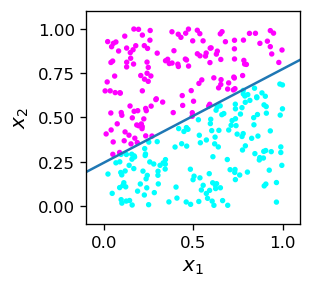

In [14]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(samp2[:,0],samp2[:,1],c=samp2[:,2],s=5,cmap=mpl.cm.cool)

plt.plot(lin[0],lin[1]) # plot the obtained separating line

plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12) 

plt.show()

We can see that the algorithm works! All the pink points are above the dividing line, and all the blue ones below. Let us emphasize that the dividing line, given by the equation 

$$ w_0+x_1 w_1 + x_2 w_2=0,$$

does not result from our a priori knowledge, but from the training of the MCP neuron which sets its weights. 


```{note}
One can prove that the perceptron algorithm converges if and only if the data are linearly separable. 
```

We may now reveal our secret! The data of the training sample **samp2** were labeled at the time of creation with the rule 

$$ x_2>0.25+0.52 x_1, $$

which corresponds to the weights $w_0^c=0.25$, $w_1^c=-0.52$, $w_2^c=1$. 

In [15]:
w_c=np.array([-0.25,-0.52,1]) # weights used for labeling the training sample
print(w_c)

[-0.25 -0.52  1.  ]


Note that these are not at all the same as the weights obtained from the training:

In [16]:
print(np.round(w_o,3))

[-0.452 -0.971  1.842]


The reason is twofold. First, note that the inequality condition {eq}`eq-linsep` is unchanged if we multiply both sides by a **positive** constant $c$. We may therefore scale all the weight by $c$, and the situation (the answers of the MCP neuron, the dividing line) remains exactly the same (we encounter here an **equivalence class** of weights scaled with a positive factor). 

For that reason, when we divide correspondingly the obtained weights by the weights used to label the sample, we get (almost) constant values: 

In [17]:
print(np.round(w_o/w_c,3))

[1.809 1.868 1.842]


The reason why the ratio values for $i=0,1,2$ are not exactly the same is that the sample has a finite number of points (here 300). Thus, there is always some gap between the two classes of points and there is some room for "jiggling" the separating line a bit. With more data points this mismatch effect decreases (see the exercises). 

### Testing the classifier

Due to the limited size of the training sample and the "jiggling" effect desribed above, the classification result on a test sample is sometimes wrong. This always applies to the points near the dividing line, which is determined with accuracy depending on the multiplicity of the training sample. The code below carries out the check on a test sample. The test sample consists of labeled data generated randomly "on the flight" with the same function **point2** used to generate the training data before: 

In [18]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):           # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

The code for testing is as follows:

In [19]:
er= np.empty((0,3))  # initialize an empty 1 x 3 array to store misclassified points

ner=0                 # initial number of misclassified points
nt=10000               # number of test points

for _ in range(nt):   # loop over the test points
    ps=point2()       # a test point 
    if(func.neuron(ps[:2],[w0,w1,w2])!=ps[2]): # if wrong answer                                      
        er=np.append(er,[ps],axis=0)           # add the point to er
        ner+=1                                 # count the number of errors
        
print("number of misclassified points = ",ner," per ",nt," (", np.round(ner/nt*100,1),"% )")        

number of misclassified points =  14  per  10000  ( 0.1 % )


As we can see, a small number of test points are misclassified. All these points lie near the separating line. 

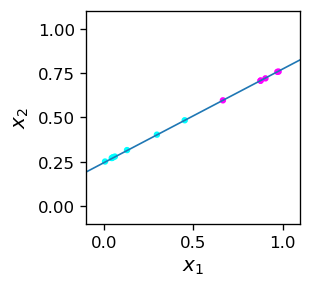

In [20]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(er[:,0],er[:,1],c=er[:,2],s=8,cmap=mpl.cm.cool)

plt.plot(lin[0],lin[1],linewidth=1) # plot the obtained separating line

plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)

plt.show()

```{admonition} Misclassification
:class: note

As it became clear, the reason for misclassification comes from the fact that the training sample does not determine the separating line precisely, but with some uncertainty, as there is a gap between the points of the training sample. For a better result, the training points would have to be "denser" in the vicinity of the separating line, or the training sample would have to be larger. 
```

## Exercises

```{admonition} $~$
:class: warning

- Play with the lecture code and see how the percentage of misclassified points decreases with the increasing size of the training sample.
- As the perceptron algorithm converges, at some point the weights stop to change. Improve the lecture code by implementing stopping when the weights do not change more than some value when passing to the next round. 
- Generalize the above classifier to points in 3-dimensional space.
```